In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
train = pd.read_csv("../../scene-classification/train.csv")

In [3]:
from keras.preprocessing import image

train_image = []
for i in range(train.shape[0]):
#     print(train['image_name'][i])
    img = image.load_img('../../scene-classification/train/'+train['image_name'][i], target_size=(150,150,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

Using TensorFlow backend.


In [4]:
from keras.utils import to_categorical
y=train['label'].values
y = to_categorical(y)

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

# print shape of training set
print('x_train shape:', x_train.shape)
# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (10901, 150, 150, 3)
10901 train samples
3407 test samples
2726 validation samples


In [6]:
from keras.applications.vgg16 import VGG16
# vgg_conv = VGG16(weights = 'imagenet',include_top = False,input_shape = (150,150,3))
# vgg_conv = VGG16(weights = '../../model_weights/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5',
#                  include_top = True,input_shape = (150,150,3))

In [7]:
# vgg_conv.summary()

In [8]:
import tensorflow as tf
# print(tf.__version__)

# for layer in vgg_conv.layers[8:]:
#     layer.trainable = True

# for layer in vgg_conv.layers:
#     print(layer,layer.trainable)

In [9]:
from keras import models,layers,optimizers
model_vgg = models.Sequential()
# model_vgg.add(vgg_conv)
# model_vgg.add(layers.Flatten())
model_vgg.add(layers.Flatten(input_shape=(150,150,3)))
model_vgg.add(layers.Dense(256, activation='relu', input_dim=(150*150*3)))
model_vgg.add(layers.Dense(512,  activation='relu'))
model_vgg.add(layers.Dense(512,  activation='relu'))
model_vgg.add(layers.Dropout(0.4))
model_vgg.add(layers.Dense(6,activation = 'softmax'))
model_vgg.load_weights('../../model_weights/resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
model_vgg.summary()

W1003 07:28:18.794724 140717704537856 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1003 07:28:18.814189 140717704537856 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1003 07:28:18.825285 140717704537856 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1003 07:28:18.866037 140717704537856 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The n

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               17280256  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 3078      
Total params: 17,677,574
Trainable params: 17,677,574
Non-trainable params: 0
________________________________________________________________

In [10]:
# model_vgg.compile(loss='categorical_crossentropy',optimizer = optimizers.RMSprop(lr=1e-4),metrics=['acc'])
model_vgg.compile(optimizer=optimizers.Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

W1003 07:28:19.285143 140717704537856 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1003 07:28:19.293659 140717704537856 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping   

# train the model
# checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='loss', patience=3)
history = model_vgg.fit(x_train, y_train, batch_size=16, epochs=20, validation_data=(x_valid, y_valid), verbose=1, shuffle=True, callbacks=[earlystopping])


W1003 07:28:19.404067 140717704537856 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10901 samples, validate on 2726 samples
Epoch 1/20
10901/10901 [==============================] - 21s 2ms/step - loss: 1.5090 - acc: 0.4069 - val_loss: 1.3307 - val_acc: 0.4857
Epoch 2/20
10901/10901 [==============================] - 19s 2ms/step - loss: 1.3283 - acc: 0.4773 - val_loss: 1.2388 - val_acc: 0.5110
Epoch 3/20
10901/10901 [==============================] - 19s 2ms/step - loss: 1.2430 - acc: 0.5195 - val_loss: 1.2287 - val_acc: 0.5249
Epoch 4/20
10901/10901 [==============================] - 19s 2ms/step - loss: 1.2055 - acc: 0.5291 - val_loss: 1.2017 - val_acc: 0.5547
Epoch 5/20
10901/10901 [==============================] - 19s 2ms/step - loss: 1.1546 - acc: 0.5644 - val_loss: 1.1141 - val_acc: 0.5756
Epoch 6/20
10901/10901 [==============================] - 19s 2ms/step - loss: 1.1213 - acc: 0.5716 - val_loss: 1.1393 - val_acc: 0.5745
Epoch 7/20
10901/10901 [==============================] - 19s 2ms/step - loss: 1.0879 - acc: 0.5875 - val_loss: 1.1319 - val_acc:

In [12]:
model_vgg.save("../../model_weights/resnet101-places365.h5")

In [13]:
# evaluate and print test accuracy
score = model_vgg.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.5653067214645736


In [14]:
# get predictions on the test set
y_hat = model_vgg.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
classification_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [15]:
import matplotlib.pyplot as plt
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(classification_labels[pred_idx], classification_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

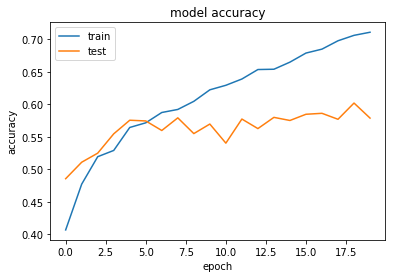

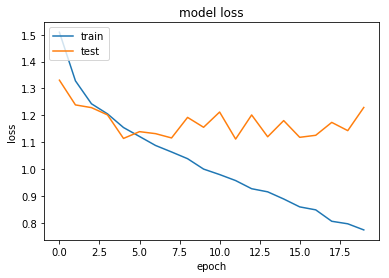

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()